In [1]:
%cd ../..

C:\Users\Wight\PycharmProjects\ThesisMain


In [2]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm

from PIL import Image
import os
import models.ViCCT.ViCCTModels  # Need to register the models!
from timm.models import create_model
from datasets.dataset_utils import img_equal_unsplit
import importlib
import time

In [3]:
model_name = 'ViCCT_base'  # Must be something like 'deit_small_distilled_patch16_224'.
trained_model_path = 'save_state_ep_660_new_best_MAE_6.536.pth'  # The path to trained model file (something like XYZ.pth)
label_factor = 3000  # The label factor used to train this specific model.
dataset = 'SHTB_ViCCT'  # Must be the exact name of the dataset
save_results = False  # When true, save the images, GTs and predictions. A folder for this is created automatically.
set_to_eval = 'test'  # val', 'test'. Which split to test the model on. 'train' does not work!

# Prepare for evaluation
Use the settings to load the DeiT model and dataloader for the test set. Also loads the transform with which we can restore the original images. Cuda is required!
If save_results is True, also create the directory in which the predictions are saved.

In [4]:
model = create_model(
        model_name,
        init_path=None,
        num_classes=1000,  # Not yet used anyway. Must match pretrained model!
        drop_rate=0.,
        drop_path_rate=0.,  
        drop_block_rate=None,
    )

model.cuda()

resume_state = torch.load(trained_model_path)
model.load_state_dict(resume_state['net'])

model.eval()

FileNotFoundError: [Errno 2] No such file or directory: 'save_state_ep_660_new_best_MAE_6.536.pth'

In [5]:
dataloader = importlib.import_module(f'datasets.standard.{dataset}.loading_data').loading_data
cfg_data = importlib.import_module(f'datasets.standard.{dataset}.settings').cfg_data

train_loader, val_loader, test_loader, restore_transform = dataloader(model.crop_size)
if set_to_eval == 'val':
    my_dataloader = val_loader
elif set_to_eval == 'test':
    my_dataloader = test_loader
else:
    print(f'Error: invalid set --> {set_to_eval}')

320 train images found.
80 val images found.
316 test images found.


In [6]:
save_path = None
if save_results:
    save_folder = 'DeiT' + '_' + dataset + '_' + set_to_eval + '_' + time.strftime("%m-%d_%H-%M", time.localtime())
    save_path = os.path.join('notebooks', save_folder)  # Manually change here is you want to save somewhere else
    os.mkdir(save_path)

# Evaluation loop and save funtion

In [7]:
def plot_and_save_results(save_path, img, img_idx, gt, prediction, pred_cnt, gt_cnt):
    img_save_path = os.path.join(save_path, f'IMG_{img_idx}_AE_{abs(pred_cnt - gt_cnt):.3f}.jpg')
    
    plt.figure()
    f, axarr = plt.subplots(1, 3, figsize=(13, 13))
    axarr[0].imshow(img)
    axarr[1].imshow(gt, cmap=cm.jet)
    axarr[1].title.set_text(f'GT count: {gt_cnt:.3f}')
    axarr[2].imshow(prediction, cmap=cm.jet)
    axarr[2].title.set_text(f'predicted count: {pred_cnt:.3f}')
    plt.tight_layout()
    plt.savefig(img_save_path)
    plt.close('all')

In [8]:
def eval_model(model, my_dataloader, show_predictions, restore_transform, label_factor, cfg_data):
    with torch.no_grad():
        AEs = []  # Absolute Errors
        SEs = []  # Squared Errors
        GTs = []
        preds = []

        for idx, (img, img_patches, gt_patches) in enumerate(my_dataloader):
            img_patches = img_patches.squeeze().cuda()
            gt_patches = gt_patches.squeeze().unsqueeze(1)  # Remove batch dim, insert channel dim
            img = img.squeeze()  # Remove batch dimension
            _, img_h, img_w = img.shape  # Obtain image dimensions. Used to reconstruct GT and Prediction
            
            img = restore_transform(img)

            pred_den = model(img_patches)  # Precicted density crops
            pred_den = pred_den.cpu()

            # Restore GT and Prediction
            gt = img_equal_unsplit(gt_patches, cfg_data.OVERLAP, cfg_data.IGNORE_BUFFER, img_h, img_w, 1)
            den = img_equal_unsplit(pred_den, cfg_data.OVERLAP, cfg_data.IGNORE_BUFFER, img_h, img_w, 1)
            gt = gt.squeeze()  # Remove channel dim
            den = den.squeeze()  # Remove channel dim
            
            
            pred_cnt = den.sum() / label_factor
            gt_cnt = gt.sum() / cfg_data.LABEL_FACTOR
            
            AEs.append(torch.abs(pred_cnt - gt_cnt).item())
            SEs.append(torch.square(pred_cnt - gt_cnt).item())
            GTs.append(gt_cnt.item())
            preds.append(pred_cnt.item())
            relative_error = AEs[-1] / gt_cnt * 100
            print(f'IMG {idx:<3} '
                  f'Prediction: {pred_cnt:<9.3f} '
                  f'GT: {gt_cnt:<9.3f} '
                  f'Absolute Error: {AEs[-1]:<9.3f} '
                  f'Relative Error: {relative_error:.1f}%')
            
            if save_path:
                plot_and_save_results(save_path, img, idx, gt, den, pred_cnt, gt_cnt)
            
        MAE = np.mean(AEs)
        MSE = np.sqrt(np.mean(SEs))

    return MAE, MSE, GTs, preds

In [9]:
MAE, MSE, GTs, preds = eval_model(model, my_dataloader, save_path, restore_transform, label_factor, cfg_data)
print(f'MAE/MSE: {MAE:.3f}/{MSE:.3f}')

IMG 0   Prediction: 23.442    GT: 22.930    Absolute Error: 0.512     Relative Error: 2.2%
IMG 1   Prediction: 167.061   GT: 178.575   Absolute Error: 11.514    Relative Error: 6.4%
IMG 2   Prediction: 145.263   GT: 156.916   Absolute Error: 11.654    Relative Error: 7.4%
IMG 3   Prediction: 35.942    GT: 36.641    Absolute Error: 0.699     Relative Error: 1.9%
IMG 4   Prediction: 65.222    GT: 69.678    Absolute Error: 4.456     Relative Error: 6.4%
IMG 5   Prediction: 59.214    GT: 56.930    Absolute Error: 2.283     Relative Error: 4.0%
IMG 6   Prediction: 43.093    GT: 43.860    Absolute Error: 0.768     Relative Error: 1.7%
IMG 7   Prediction: 213.948   GT: 224.494   Absolute Error: 10.546    Relative Error: 4.7%
IMG 8   Prediction: 165.519   GT: 164.729   Absolute Error: 0.790     Relative Error: 0.5%
IMG 9   Prediction: 471.397   GT: 474.624   Absolute Error: 3.228     Relative Error: 0.7%
IMG 10  Prediction: 129.373   GT: 138.824   Absolute Error: 9.452     Relative Error: 6.8%

IMG 90  Prediction: 101.253   GT: 100.175   Absolute Error: 1.078     Relative Error: 1.1%
IMG 91  Prediction: 62.206    GT: 59.964    Absolute Error: 2.243     Relative Error: 3.7%
IMG 92  Prediction: 226.169   GT: 250.483   Absolute Error: 24.314    Relative Error: 9.7%
IMG 93  Prediction: 170.627   GT: 186.611   Absolute Error: 15.985    Relative Error: 8.6%
IMG 94  Prediction: 184.636   GT: 183.354   Absolute Error: 1.282     Relative Error: 0.7%
IMG 95  Prediction: 103.686   GT: 105.446   Absolute Error: 1.760     Relative Error: 1.7%
IMG 96  Prediction: 97.380    GT: 103.138   Absolute Error: 5.759     Relative Error: 5.6%
IMG 97  Prediction: 147.036   GT: 159.000   Absolute Error: 11.964    Relative Error: 7.5%
IMG 98  Prediction: 56.633    GT: 56.000    Absolute Error: 0.633     Relative Error: 1.1%
IMG 99  Prediction: 39.481    GT: 39.207    Absolute Error: 0.274     Relative Error: 0.7%
IMG 100 Prediction: 271.903   GT: 276.673   Absolute Error: 4.770     Relative Error: 1.7%

IMG 180 Prediction: 194.050   GT: 183.371   Absolute Error: 10.679    Relative Error: 5.8%
IMG 181 Prediction: 142.210   GT: 137.000   Absolute Error: 5.210     Relative Error: 3.8%
IMG 182 Prediction: 98.348    GT: 95.000    Absolute Error: 3.348     Relative Error: 3.5%
IMG 183 Prediction: 33.764    GT: 36.000    Absolute Error: 2.236     Relative Error: 6.2%
IMG 184 Prediction: 26.519    GT: 27.233    Absolute Error: 0.714     Relative Error: 2.6%
IMG 185 Prediction: 56.109    GT: 58.563    Absolute Error: 2.454     Relative Error: 4.2%
IMG 186 Prediction: 64.173    GT: 61.611    Absolute Error: 2.562     Relative Error: 4.2%
IMG 187 Prediction: 81.346    GT: 78.880    Absolute Error: 2.466     Relative Error: 3.1%
IMG 188 Prediction: 336.191   GT: 302.890   Absolute Error: 33.301    Relative Error: 11.0%
IMG 189 Prediction: 210.269   GT: 206.883   Absolute Error: 3.386     Relative Error: 1.6%
IMG 190 Prediction: 144.236   GT: 141.153   Absolute Error: 3.083     Relative Error: 2.2

IMG 270 Prediction: 102.790   GT: 95.245    Absolute Error: 7.544     Relative Error: 7.9%
IMG 271 Prediction: 46.535    GT: 47.743    Absolute Error: 1.207     Relative Error: 2.5%
IMG 272 Prediction: 197.920   GT: 194.752   Absolute Error: 3.168     Relative Error: 1.6%
IMG 273 Prediction: 29.959    GT: 33.414    Absolute Error: 3.455     Relative Error: 10.3%
IMG 274 Prediction: 409.692   GT: 408.728   Absolute Error: 0.964     Relative Error: 0.2%
IMG 275 Prediction: 164.072   GT: 171.548   Absolute Error: 7.476     Relative Error: 4.4%
IMG 276 Prediction: 60.842    GT: 59.589    Absolute Error: 1.253     Relative Error: 2.1%
IMG 277 Prediction: 48.939    GT: 49.137    Absolute Error: 0.198     Relative Error: 0.4%
IMG 278 Prediction: 228.529   GT: 231.781   Absolute Error: 3.252     Relative Error: 1.4%
IMG 279 Prediction: 171.278   GT: 173.766   Absolute Error: 2.488     Relative Error: 1.4%
IMG 280 Prediction: 109.847   GT: 107.652   Absolute Error: 2.196     Relative Error: 2.0

In [10]:
img_nrs = np.arange(len(GTs))
sorted_idxs = np.argsort(GTs)
GTs = np.array(GTs)
preds = np.array(preds)

plt.rcParams.update({'font.size': 14})

plt.figure()
plt.plot(img_nrs, GTs[sorted_idxs], label='Ground truths')
plt.plot(img_nrs, preds[sorted_idxs], label='Predictions')
plt.ylabel('Crowd count')
plt.xlabel('Sorted image')
plt.legend()
plt.tight_layout()
# plt.savefig(f'DeiT_{dataset}_pred_vs_gt.jpg')
plt.show()

SyntaxError: invalid syntax (<ipython-input-10-e180b5915acc>, line 16)

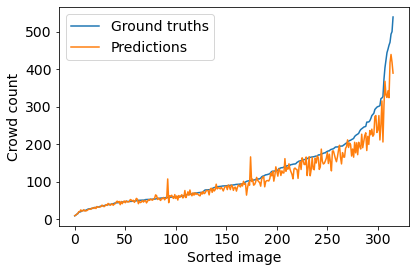

In [10]:
img_nrs = np.arange(len(GTs))
sorted_idxs = np.argsort(GTs)
GTs = np.array(GTs)
preds = np.array(preds)

plt.rcParams.update({'font.size': 14})

plt.figure()
plt.plot(img_nrs, GTs[sorted_idxs], label='Ground truths')
plt.plot(img_nrs, preds[sorted_idxs], label='Predictions')
plt.ylabel('Crowd count')
plt.xlabel('Sorted image')
plt.legend()
plt.tight_layout()
# plt.savefig(f'DeiT_{dataset}_pred_vs_gt.jpg')
plt.show()

IMG 251, pred: 211.419, gt: 326.572. Error: -115.153


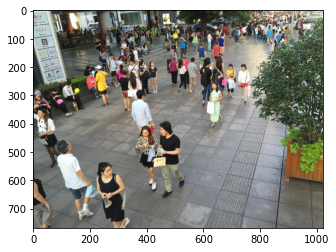

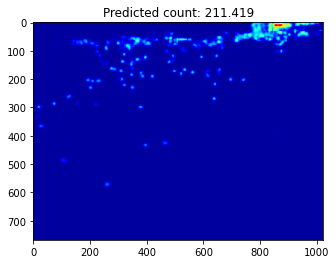

IMG 288, pred: 157.846, gt: 258.733. Error: -100.887


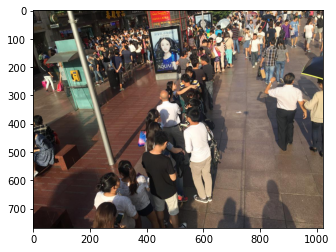

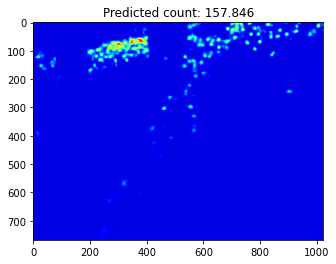

IMG 11, pred: 206.493, gt: 302.806. Error: -96.314


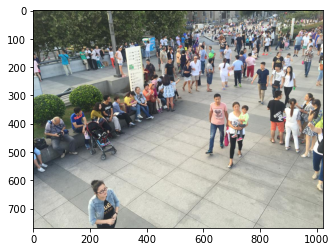

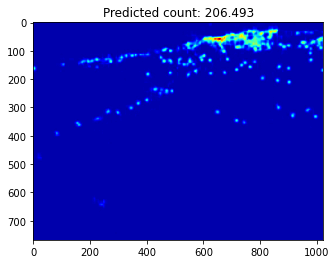

IMG 289, pred: 443.687, gt: 538.860. Error: -95.173


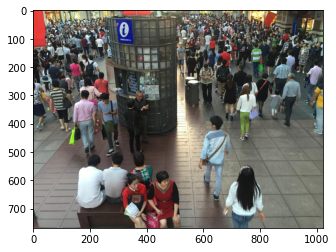

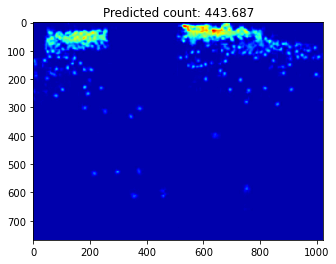

IMG 133, pred: 362.729, gt: 443.772. Error: -81.043


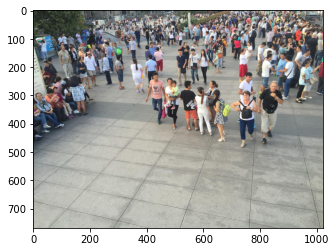

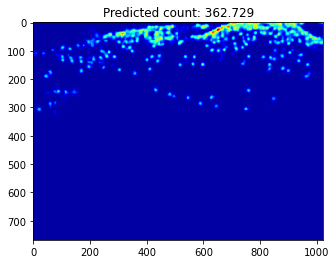

IMG 153, pred: 258.188, gt: 321.270. Error: -63.083


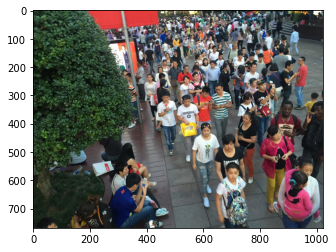

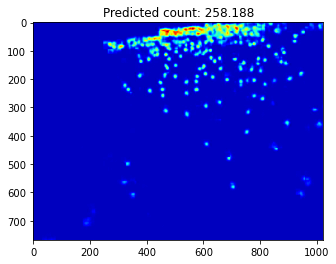

IMG 295, pred: 406.783, gt: 463.567. Error: -56.784


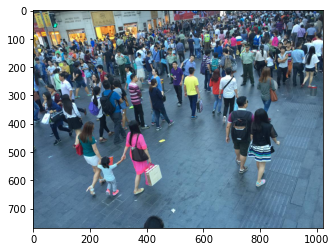

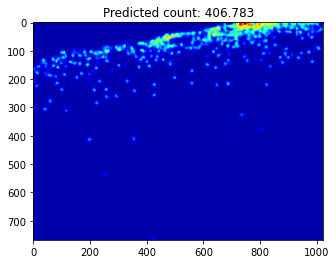

IMG 163, pred: 316.702, gt: 372.408. Error: -55.706


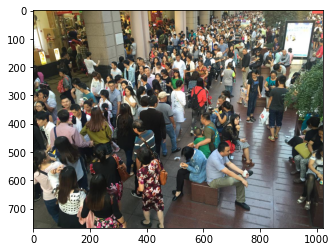

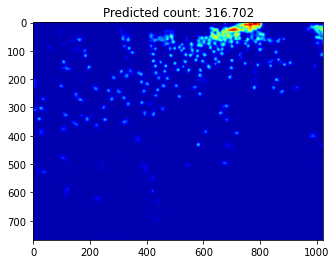

IMG 134, pred: 248.380, gt: 298.524. Error: -50.144


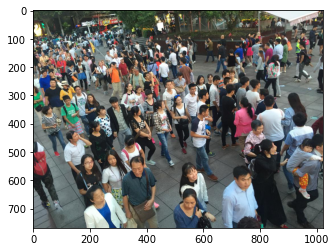

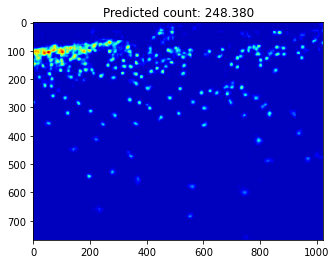

IMG 102, pred: 251.956, gt: 300.155. Error: -48.198


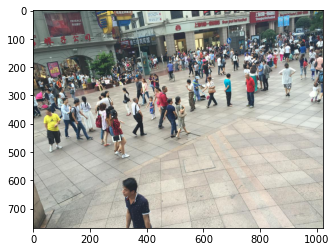

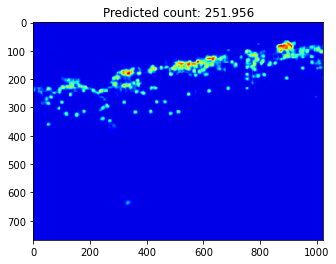

In [11]:
sorted_error_idxs = np.flip(np.argsort(np.abs(GTs - preds)))

with torch.no_grad():
    for idx in sorted_error_idxs[:10]:
        img, img_patches, gt_patches = my_dataloader.dataset.__getitem__(idx)

        img_patches = img_patches.cuda()
        gt_patches = gt_patches.squeeze().unsqueeze(1)  # Remove batch dim, insert channel dim
        img = img.squeeze()  # Remove batch dimension
        _, img_h, img_w = img.shape  # Obtain image dimensions. Used to reconstruct GT and Prediction

        img = restore_transform(img)

        pred_den = model(img_patches)  # Precicted density crops
        pred_den = pred_den.cpu()
        
        # Restore GT and Prediction
        gt = img_equal_unsplit(gt_patches, cfg_data.OVERLAP, cfg_data.IGNORE_BUFFER, img_h, img_w, 1)
        den = img_equal_unsplit(pred_den, cfg_data.OVERLAP, cfg_data.IGNORE_BUFFER, img_h, img_w, 1)
        gt = gt.squeeze()  # Remove channel dim
        den = den.squeeze()  # Remove channel dim


        pred_cnt = den.sum() / label_factor
        gt_cnt = gt.sum() / cfg_data.LABEL_FACTOR

        print(f'IMG {idx}, pred: {pred_cnt:.3f}, gt: {gt_cnt:.3f}. Error: {pred_cnt - gt_cnt:.3f}')
        
        plt.figure()
        plt.imshow(np.asarray(img))
#         plt.savefig(f'DeiT_IMG_{idx + 1}_{dataset}.jpg')
        plt.show()
        
        
        plt.figure()
        plt.imshow(den.numpy(), cmap=cm.jet)
        plt.title(f'Predicted count: {pred_cnt:.3f}')
#         plt.savefig(f'DeiT_IMG_{idx + 1}_{dataset}_prediction.jpg')
        plt.show()

IMG 74, pred: 168.145, gt: 168.117. Error: 0.028


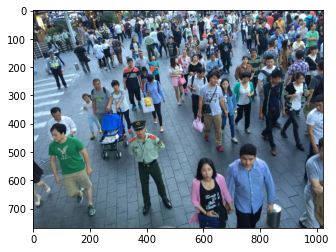

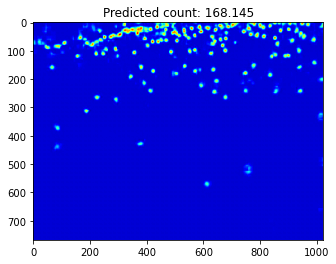

IMG 26, pred: 50.704, gt: 50.748. Error: -0.044


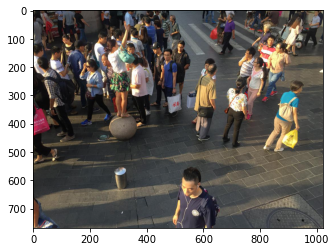

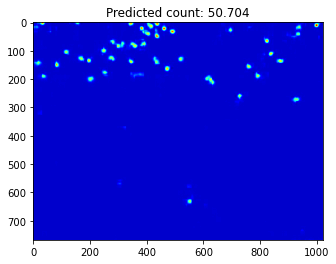

IMG 191, pred: 52.767, gt: 52.836. Error: -0.070


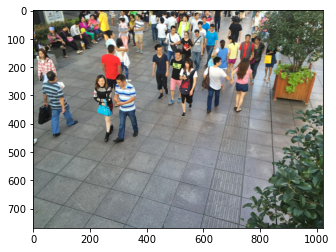

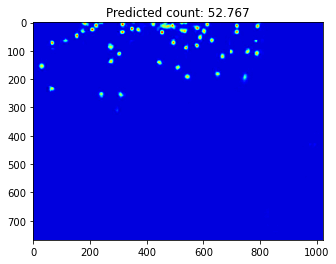

IMG 77, pred: 124.823, gt: 124.731. Error: 0.092


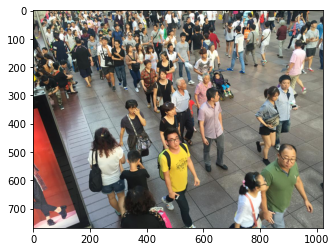

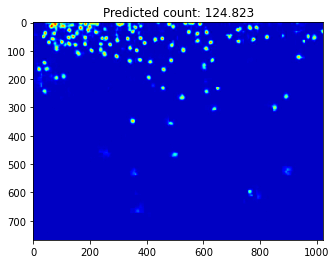

IMG 154, pred: 50.232, gt: 50.139. Error: 0.093


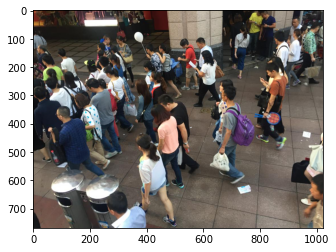

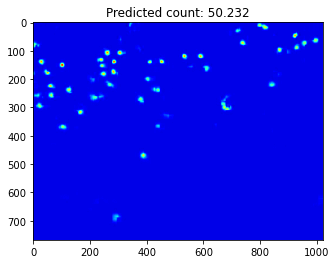

IMG 249, pred: 47.502, gt: 47.392. Error: 0.110


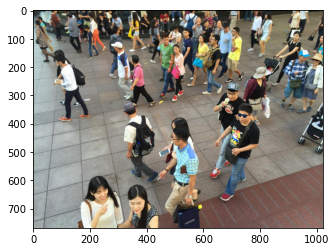

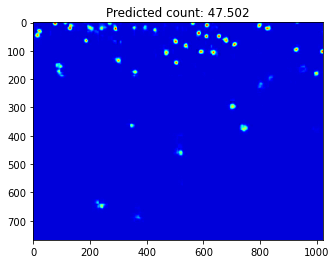

IMG 126, pred: 137.321, gt: 137.188. Error: 0.133


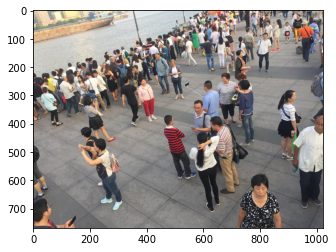

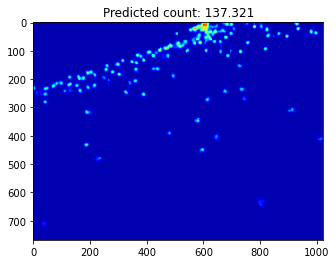

IMG 284, pred: 47.479, gt: 47.339. Error: 0.140


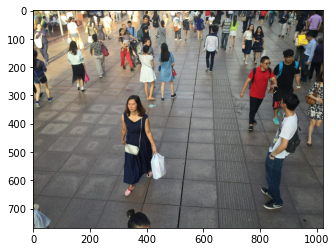

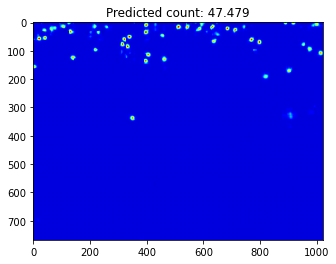

IMG 282, pred: 92.958, gt: 93.117. Error: -0.159


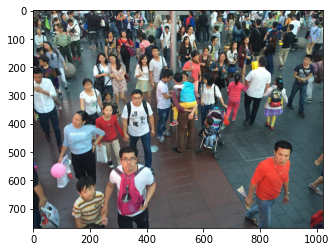

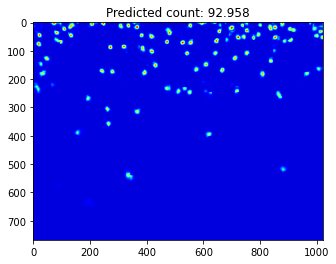

IMG 63, pred: 42.455, gt: 42.275. Error: 0.180


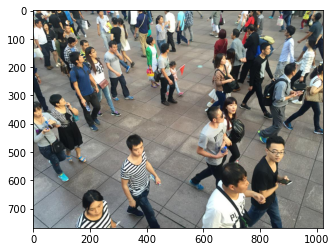

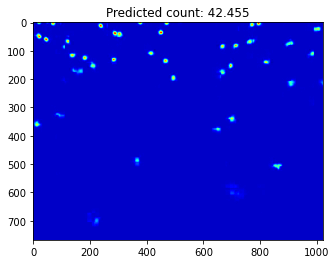

In [12]:
sorted_good_idxs = np.argsort(np.abs(GTs - preds))

with torch.no_grad():
    for idx in sorted_good_idxs[:10]:
        img, img_patches, gt_patches = my_dataloader.dataset.__getitem__(idx)

        img_patches = img_patches.cuda()
        gt_patches = gt_patches.squeeze().unsqueeze(1)  # Remove batch dim, insert channel dim
        img = img.squeeze()  # Remove batch dimension
        _, img_h, img_w = img.shape  # Obtain image dimensions. Used to reconstruct GT and Prediction

        img = restore_transform(img)

        pred_den = model(img_patches)  # Precicted density crops
        pred_den = pred_den.cpu()
        
        # Restore GT and Prediction
        gt = img_equal_unsplit(gt_patches, cfg_data.OVERLAP, cfg_data.IGNORE_BUFFER, img_h, img_w, 1)
        den = img_equal_unsplit(pred_den, cfg_data.OVERLAP, cfg_data.IGNORE_BUFFER, img_h, img_w, 1)
        gt = gt.squeeze()  # Remove channel dim
        den = den.squeeze()  # Remove channel dim


        pred_cnt = den.sum() / label_factor
        gt_cnt = gt.sum() / cfg_data.LABEL_FACTOR

        print(f'IMG {idx}, pred: {pred_cnt:.3f}, gt: {gt_cnt:.3f}. Error: {pred_cnt - gt_cnt:.3f}')
        
        plt.figure()
        plt.imshow(np.asarray(img))
#         plt.savefig(f'DeiT_IMG_{idx + 1}_{dataset}.jpg')
        plt.show()
        
        
        plt.figure()
        plt.imshow(den.numpy(), cmap=cm.jet)
        plt.title(f'Predicted count: {pred_cnt:.3f}')
#         plt.savefig(f'DeiT_IMG_{idx + 1}_{dataset}_prediction.jpg')
        plt.show()